# Programming Challenge

In [29]:
def triangle(n):
  # Iterating through the rows
  for i in range(n, 0, -1):
    # Printing the numbers in the row
    for j in range(n-i+1, n+1):
        print(j, end=' ')
    # Move to the next line after printing the row
    print()

In [30]:
triangle(10)

1 2 3 4 5 6 7 8 9 10 
2 3 4 5 6 7 8 9 10 
3 4 5 6 7 8 9 10 
4 5 6 7 8 9 10 
5 6 7 8 9 10 
6 7 8 9 10 
7 8 9 10 
8 9 10 
9 10 
10 


In [31]:
triangle(6)

1 2 3 4 5 6 
2 3 4 5 6 
3 4 5 6 
4 5 6 
5 6 
6 


In [32]:
triangle(3)

1 2 3 
2 3 
3 


# Name Generation – Challenge

In [1]:
import numpy as np
import re

In [61]:
# readin the dataset and Preprocessing
data = open('hospitals.txt', 'r').read()
data= data.lower()

In [63]:
reg_list = [i.split()[0:2] for i in data.split('\n')]

# taking unique words and the word length should be at least 5 characters
flat_list = list(set([item for sublist in reg_list for item in sublist if len(item)>5]))
len(flat_list)

names = flat_list.copy()
print(len(names))

2000


The last thing that will be useful to do is add a '.' at the end of each name. This will be useful to tell the RNN that the name is over.

In [36]:
names = list(map(lambda s: s + '.', names))
names[:10]

['passavant.',
 'opelousas.',
 'wesley.',
 'caldwell.',
 'midstate.',
 'northside.',
 'lakeland.',
 'willis.',
 'wilcox.',
 'bridge.']

Removing the special characters in the names

In [43]:
names = [re.sub('[^a-zA-Z0-9]+', '', _) for _ in names]

## Transform the data

Now that we have our data cleaned up it's time to transform it into a form that the neural network will understand. The details of the model will be explained later but all we need to know is that we will input characters into the network instead of words. Each of these characters will then be converted to numbers and the conversion is done using the following dictionary:

In [44]:
# Convert from character to index
char_to_index = dict( (chr(i+96), i) for i in range(1,27))
char_to_index[' '] = 0
char_to_index['.'] = 27

# Convert from index to character
index_to_char = dict( (i, chr(i+96)) for i in range(1,27))
index_to_char[0] = ' '
index_to_char[27] = '.'

We need to define a few constants that will be useful later.

In [45]:
# maximum number of characters in hospital names
# this will be the number of time steps in the RNN
max_char = len(max(names, key=len))

# number of elements in the list of names, this is the number of training examples which is 2000 in our case
m = len(names)

# number of potential characters, this is the length of the input of each of the RNN units
char_dim = len(char_to_index)

Finally we convert the list of names into a training dataset. The input X of the network is an array of size (m, max_char, char_dim). It contains a matrix for each of the m names. Each matrix contains a row for each character in the name. (Note that there are always the same number of rows and if the name doesn't have enough characters to fill the whole matrix the remaining rows contain nothing.) Each of these rows represents one character and it is encoded as a one-hot vector. This means that it is a vector of zeros with a one only in the entry that corresponds to the character that is present.

The output Y is the same as the input but translated by one unit. This means that the ith character in Y is the (i+1)th one in the actual name. This means that the network predicts the character that follows a given character in a sequence. 

In [46]:
X = np.zeros((m, max_char, char_dim))
Y = np.zeros((m, max_char, char_dim))

for i in range(m):
    name = list(names[i])
    for j in range(len(name)):
        X[i, j, char_to_index[name[j]]] = 1
        if j < len(name)-1:
            Y[i, j, char_to_index[name[j+1]]] = 1

## RNN model

The model that we will use is a many-to-many recurrent neural network. This is a network that contains a given number of 'time' steps that each act with the same weights on the individual inputs and are all connected. Each time step takes in one input (in this case one character) and outputs a one-hot vector that represents the probabilities for the input of the next time step. 

In [47]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import LambdaCallback

To train a deep learning model to generate new hospital names, we can use a single layer of an LSTM with 128 units and a fully connected dense layer that converts the output of the LSTM layer into a vector of size 'char_dim' using a softmax activation. We can use categorical cross entropy as the cost function and Adam optimization. The performance of the model can be evaluated by examining the generated hospital names.

In [48]:
model = Sequential()
model.add(LSTM(128, input_shape=(max_char, char_dim), return_sequences=True))
model.add(Dense(char_dim, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam')

To generate new hospital names using a trained deep learning model, we can input empty characters to the model and use the output of the first time step as a probability distribution for the first letter of the name. We can then use this distribution to randomly select the first character, record it, and update the input to pass this character as input for the next time step. 

This process can be repeated for the following time steps until a '.' character is generated, indicating that the name is complete. If the length of the generated name exceeds the length of the longest name in the training set, we can also end the process by inserting a '.' character.

In [56]:
def make_name(model):
    name = []
    x = np.zeros((1, max_char, char_dim))
    end = False
    i = 0
    
    while end==False:
        probs = list(model.predict(x)[0,i])
        probs = probs / np.sum(probs)
        index = np.random.choice(range(char_dim), p=probs)
        if i == max_char-2:
            character = '.'
            end = True
        else:
            character = index_to_char[index]
        name.append(character)
        x[0, i+1, index] = 1
        i += 1
        if character == '.':
            end = True
    
    print(''.join(name))
    return ''.join(name)

Now we want to use this function during the training to monitor how the generated names get better. To this end we create a function that will be given to the model when we fit it. We basically run the previous function a few times every 50 epochs and print the results.

In [50]:
def generate_name_loop(epoch, _):
    if epoch % 25 == 0:
        
        print('Names generated after epoch %d:' % epoch)

        for i in range(3):
            make_name(model)
        
        print()

This converts the function to be able to use it in keras.

In [51]:
name_generator = LambdaCallback(on_epoch_end = generate_name_loop)

We fit the model with the function and look at the results. It is clear that the names make more and more sense as we train.

In [52]:
model.fit(X, Y, batch_size=64, epochs=300, callbacks=[name_generator], verbose=0)

Names generated after epoch 0:
1/1 [==============================] - 0s 51ms/step
eacawjgnregaod.
1/1 [==============================] - 0s 52ms/step
yfecmqneaoho.
1/1 [==============================] - 0s 42ms/step
mseiiotoliochj.

Names generated after epoch 25:
1/1 [==============================] - 0s 50ms/step
taieheodha.
1/1 [==============================] - 0s 44ms/step
kaameoeoh kqop.
1/1 [==============================] - 0s 50ms/step
prweweohhahble.

Names generated after epoch 50:
1/1 [==============================] - 0s 50ms/step
avrldoodyozrga.
1/1 [==============================] - 0s 50ms/step
efec .
1/1 [==============================] - 0s 52ms/step
.

Names generated after epoch 75:
1/1 [==============================] - 0s 43ms/step
hmgnaloiaohlrr.
1/1 [==============================] - 0s 53ms/step
eftgoatccl iat.
1/1 [==============================] - 0s 49ms/step
wdodghuenuwlla.

Names generated after epoch 100:


1/1 [==============================] - 0s 59ms/step
amyloeduuuordn.
1/1 [==============================] - 0s 51ms/step
ouwcsheedh.
1/1 [==============================] - 0s 56ms/step
uimvtobjseajei.

Names generated after epoch 125:
1/1 [==============================] - 0s 57ms/step
geieelcuoh eeo.
1/1 [==============================] - 0s 49ms/step
wiks.
1/1 [==============================] - 0s 50ms/step
haiobgiiennabo.

Names generated after epoch 150:
1/1 [==============================] - 0s 46ms/step
ullvyhoausogny.
1/1 [==============================] - 0s 58ms/step
ubeo ojehlowee.
1/1 [==============================] - 0s 51ms/step
obzhohsewoohhs.

Names generated after epoch 175:
1/1 [==============================] - 0s 41ms/step
felihtrlksrlin.
1/1 [==============================] - 0s 58ms/step
heyoojaopaoias.
1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 49ms/step
logtntmoiooequ.

Names generated after epoch 200:
1/1 [==============================] - 0s 40ms/step
eafcwmrarrebwm.
1/1 [==============================] - 0s 65ms/step
rencmhgeonedeo.
1/1 [==============================] - 0s 48ms/step
mardnrjztgbcno.

Names generated after epoch 225:
1/1 [==============================] - 0s 48ms/step
claboljehditni.
1/1 [==============================] - 0s 55ms/step
coleoedonusnel.
1/1 [==============================] - 0s 47ms/step
ouagdhjeloapne.

Names generated after epoch 250:
1/1 [==============================] - 0s 58ms/step
heiobwelhqteim.
1/1 [==============================] - 0s 63ms/step
eigshientehetn.
1/1 [==============================] - 0s 65ms/step
lmztoinkaenney.

Names generated after epoch 275:
1/1 [==============================] - 0s 54ms/step


1/1 [==============================] - 0s 40ms/step
ilek.
1/1 [==============================] - 0s 48ms/step
lereomswbooinh.
1/1 [==============================] - 0s 47ms/step
phha onalyuokd.



We can no use the final trained model to generate names as we want.

In [59]:
names = []
for i in range(20):
    names.append(make_name(model) + ' hospital')

1/1 [==============================] - 0s 51ms/step
tanidsdsnaajfa.
1/1 [==============================] - 0s 51ms/step
inrrnjnbwaneer.
1/1 [==============================] - 0s 50ms/step
geeeaufkknoeed.
1/1 [==============================] - 0s 55ms/step
ziihe oodaaeya.
1/1 [==============================] - 0s 51ms/step
lertxyopneonte.
1/1 [==============================] - 0s 35ms/step
arohnishloegoe.
1/1 [==============================] - 0s 47ms/step
ennierhnnouals.
1/1 [==============================] - 0s 56ms/step
jyohnw roewfns.
1/1 [==============================] - 0s 42ms/step
daarjnetrow of.
1/1 [==============================] - 0s 52ms/step
sorehsetohnneo.
1/1 [==============================] - 0s 58ms/step


1/1 [==============================] - 0s 60ms/step
beesoenjion.
1/1 [==============================] - 0s 71ms/step
alanjrs.
1/1 [==============================] - 0s 58ms/step
mwjeorbldloawm.
1/1 [==============================] - 0s 40ms/step
aamooehjdnodit.
1/1 [==============================] - 0s 52ms/step
ou.
1/1 [==============================] - 0s 49ms/step
kiegcaislenrrj.
1/1 [==============================] - 0s 57ms/step
araroyngoecjoo.
1/1 [==============================] - 0s 49ms/step
smlltnmooavgra.
1/1 [==============================] - 0s 53ms/step
etihatlheocose.
1/1 [==============================] - 0s 43ms/step
unwvr.


In [60]:
names

['tanidsdsnaajfa. hospital',
 'inrrnjnbwaneer. hospital',
 'geeeaufkknoeed. hospital',
 'ziihe oodaaeya. hospital',
 'lertxyopneonte. hospital',
 'arohnishloegoe. hospital',
 'ennierhnnouals. hospital',
 'jyohnw roewfns. hospital',
 'daarjnetrow of. hospital',
 'sorehsetohnneo. hospital',
 'beesoenjion. hospital',
 'alanjrs. hospital',
 'mwjeorbldloawm. hospital',
 'aamooehjdnodit. hospital',
 'ou. hospital',
 'kiegcaislenrrj. hospital',
 'araroyngoecjoo. hospital',
 'smlltnmooavgra. hospital',
 'etihatlheocose. hospital',
 'unwvr. hospital']

* The generated hospital names may not make sense and it may be possible to improve the performance of the deep learning model by adjusting the hyperparameters, such as the number of units in the LSTM layer, the parameters of Adam optimization, or by adding additional LSTM layers. In addition, manual text processing techniques, such as handpicking the names, may also be required to improve the quality of the generated names

sources referred:
- https://github.com/keras-team/keras/blob/master/examples/lstm_text_generation.py
- https://machinelearningmastery.com/text-generation-lstm-recurrent-neural-networks-python-keras/
- https://towardsdatascience.com/character-level-language-model-1439f5dd87fe
- assignment 2 of week 1 of the 5th course in the deep learning specialization on Coursera

# Named Entity Classification

In [1]:
import tensorflow as tf
import pandas as pd
import re
import numpy as np

In [2]:
# reading the hospital names
data = open('hospitals.txt', 'r').read()
data= data.lower()


# reading the person names
data2 = open('names.txt', 'r').read()
data2= data2.lower()

In [3]:
# adding the class names and combining both the datasets using pandas dataframe
df = pd.DataFrame({'text': data.split('\n')})
df['class'] = 'hospital'

df2 = pd.DataFrame({'text': data2.split('\n')})
df2['class'] = 'person'

combined = df.append(df2).sample(frac = 1)
combined.reset_index(drop=True, inplace=True)
combined

,text,class
0,st luke's elmore medical center,hospital
1,rhea getler,person
2,humberto kingdon,person
3,sterling surgical hospital,hospital
4,cibola general hospital,hospital
...,...,...
18769,altha suitor,person
18770,saint thomas midtown hospital,hospital
18771,jeanetta semenza,person
18772,latoyia divis,person


In [4]:
# text pre-processing
def depure_data(data):
    
    #Removing URLs with a regular expression
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    data = url_pattern.sub(r'', data)

    # Remove Emails if any
    data = re.sub('\S*@\S*\s?', '', data)

    # Remove new line characters
    data = re.sub('\s+', ' ', data)

    # Remove distracting single quotes
    data = re.sub("\'", "", data)
        
    return data

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(combined['text'], combined['class'].values, test_size=0.2, random_state=42)

print('Training utterances: {}'.format(X_train.shape[0]))
print('Validation utterances: {}'.format(X_test.shape[0]))

Training utterances: 15019
Validation utterances: 3755


In [7]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(binary=True, ngram_range=(1, 2))
X_train_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test)

In [8]:
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Flatten, Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model, Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [9]:
# Converting the categorical values to one-hot encoding
y_train_new = pd.get_dummies(y_train)
y_test_new = pd.get_dummies(y_test)


epochs = 5
batch_size = 12
loss = "categorical_crossentropy"
optimizer = "adam"
metrics = ["accuracy"]

early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=3)

# Build neural network
bow_model = Sequential()
bow_model.add(Dense(512, activation='relu'))
bow_model.add(Dense(256, activation='relu'))
bow_model.add(Dense(2, activation='softmax'))
bow_model.compile(loss=loss, optimizer=optimizer, metrics= metrics)

In [10]:
bow_model.fit(X_train_bow.toarray(), y_train_new, validation_split = 0.2, epochs=epochs, batch_size=batch_size, callbacks=[early_stopping])

Epoch 1/5
1002/1002 [==============================] - 86s 84ms/step - loss: 0.0334 - accuracy: 0.9899 - val_loss: 0.0139 - val_accuracy: 0.9960
Epoch 2/5
1002/1002 [==============================] - 84s 84ms/step - loss: 0.0010 - accuracy: 0.9998 - val_loss: 0.0087 - val_accuracy: 0.9980
Epoch 3/5
1002/1002 [==============================] - 83s 83ms/step - loss: 3.8529e-04 - accuracy: 0.9999 - val_loss: 0.0176 - val_accuracy: 0.9967
Epoch 4/5
1002/1002 [==============================] - 82s 81ms/step - loss: 3.5854e-04 - accuracy: 0.9998 - val_loss: 0.0107 - val_accuracy: 0.9977
Epoch 5/5
1002/1002 [==============================] - 83s 83ms/step - loss: 3.4885e-04 - accuracy: 0.9999 - val_loss: 0.0885 - val_accuracy: 0.9684


## testing on the test set

In [11]:
y_pred_cl = (bow_model.predict(X_test_bow)>0.5).astype(int).argmax(axis=1)

In [12]:
y_test_cl = np.array(y_test_new).argmax(axis=1)

## printing classification report and plotting confusion matrix

	***********Classification Report*********** 
               precision    recall  f1-score   support

           0       0.71      1.00      0.83       949
           1       1.00      0.86      0.93      2806

    accuracy                           0.90      3755
   macro avg       0.85      0.93      0.88      3755
weighted avg       0.93      0.90      0.90      3755



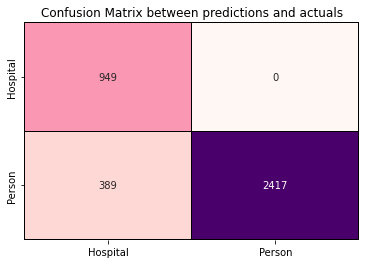

In [13]:
from sklearn.metrics import classification_report, confusion_matrix
from matplotlib import pyplot as plt
import seaborn as sns

# Making predictions on test data
# y_pred = (bow_model.predict(X_test_bow)>0.5).astype(int)
print('\t***********Classification Report*********** \n', classification_report(y_test_cl, y_pred_cl))

# Creation of confusion matrix betweeen predictions and actuals
cm = confusion_matrix(y_test_cl, y_pred_cl)
cm = pd.DataFrame(cm, index = ['Hospital', 'Person'] , columns = ['Hospital', 'Person'])

# Plotting confusion matrix
plt.title('Confusion Matrix between predictions and actuals')
sns.heatmap(cm, annot=True, fmt = '', cbar=False, cmap='RdPu', linecolor='black', linewidths=0.1);

## Using Keras word embeddings and tokenizer

This method represents words as dense word vectors (also called word embeddings) which are trained unlike the one-hot encoding which are hardcoded. This means that the word embeddings collect more information into fewer dimensions.

In [14]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train_new = tokenizer.texts_to_sequences(X_train.values)
X_test_new = tokenizer.texts_to_sequences(X_test.values)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

print(X_train[2])
print(X_train_new[2])

humberto kingdon
[100, 6, 5, 15]


In [15]:
from keras.preprocessing.sequence import pad_sequences

maxlen = 50

X_train_new = pad_sequences(X_train_new, padding='post', maxlen=maxlen)
X_test_new = pad_sequences(X_test_new, padding='post', maxlen=maxlen)

print(X_test_new[3, :])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [16]:
from keras.models import Sequential
from keras import layers

embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.Flatten())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(2, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 50)            863250    
_________________________________________________________________
flatten (Flatten)            (None, 2500)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                25010     
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 22        
Total params: 888,282
Trainable params: 888,282
Non-trainable params: 0
_________________________________________________________________


In [17]:
history = model.fit(X_train_new, y_train_new,
                    epochs=5,
                    verbose=True,
                    validation_data=(X_test_new, y_test_new),
                    batch_size=32)

loss, accuracy = model.evaluate(X_train_new, y_train_new, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test_new, y_test_new, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))


Epoch 1/5
470/470 [==============================] - 10s 18ms/step - loss: 0.3103 - accuracy: 0.8764 - val_loss: 0.1668 - val_accuracy: 0.9909
Epoch 2/5
470/470 [==============================] - 8s 17ms/step - loss: 0.1388 - accuracy: 0.9937 - val_loss: 0.1161 - val_accuracy: 0.9957
Epoch 3/5
470/470 [==============================] - 8s 17ms/step - loss: 0.0987 - accuracy: 0.9975 - val_loss: 0.0879 - val_accuracy: 0.9960
Epoch 4/5
470/470 [==============================] - 8s 17ms/step - loss: 0.0735 - accuracy: 0.9983 - val_loss: 0.0678 - val_accuracy: 0.9963
Epoch 5/5
470/470 [==============================] - 8s 17ms/step - loss: 0.0562 - accuracy: 0.9988 - val_loss: 0.0529 - val_accuracy: 0.9976
Training Accuracy: 0.9989
Testing Accuracy:  0.9976


## The model seem to be giving very good accuracy since the given text data can be classified easily in terms of usage of words in each sentence.
## This is a smaller part of a larger solution for a sentiment analysis usecase